In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
from scipy.interpolate import CubicSpline


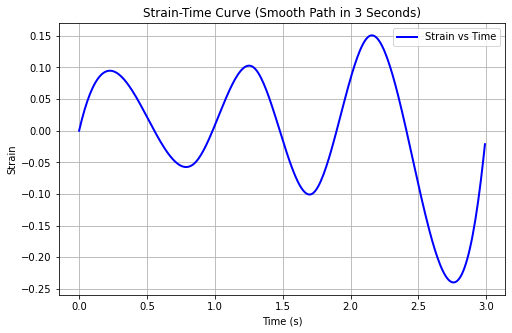

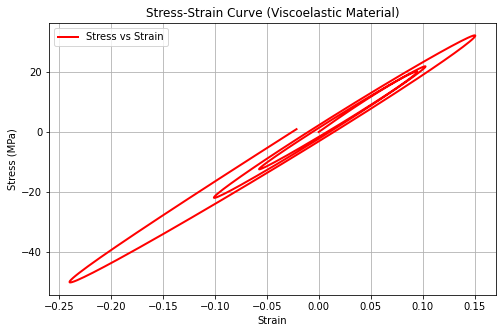

In [35]:

# Parameters for the viscoelastic model
A = 200  # Elastic stiffness matrix in MPa
Q = 10   # Kernel decay rate
D = 50   # Damping coefficient in MPa·s
dt = 0.01  # Time step

# Define time and custom strain points
total_time = 3
time = np.arange(0, total_time, dt)
custom_strain_points = [0, 0.05, -0.05, 0.1, -0.1, 0.15, -0.15, 0]
custom_time_points = np.linspace(0, total_time, len(custom_strain_points))

# Use cubic spline interpolation to create a smooth strain path
cubic_spline = CubicSpline(custom_time_points, custom_strain_points)
strain = cubic_spline(time)

# Compute the strain rate (dE/dt) using the derivative of the spline
strain_rate = cubic_spline(time, 1)  # First derivative of the strain path

# Initialize stress array
stress = np.zeros_like(time)

# Compute stress using the convolution integral
for i in range(1, len(time)):
    # Elastic stress component
    elastic_stress = A * strain[i]
    
    # Viscoelastic stress component
    viscoelastic_stress = 0
    for j in range(i):
        kernel = np.exp(-Q * (time[i] - time[j]))  # Decaying kernel
        viscoelastic_stress += kernel * D * strain_rate[j] * dt  # Convolution for viscoelastic contribution
    
    # Total stress is the sum of elastic and viscoelastic components
    stress[i] = elastic_stress + viscoelastic_stress

# Plot the strain-time curve
plt.figure(figsize=(8, 5))
plt.plot(time, strain, label="Strain vs Time", color='b', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Strain-Time Curve (Smooth Path in 3 Seconds)")
plt.grid(True)
plt.legend()
plt.show()

# Plot the stress-strain curve
plt.figure(figsize=(8, 5))
plt.plot(strain, stress, label="Stress vs Strain", color='r', linewidth=2)
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Stress-Strain Curve (Viscoelastic Material)")
plt.grid(True)
plt.legend()
plt.show()

# Convert to torch tensors for training
strain_tensor = torch.tensor(strain, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)
stress_tensor = torch.tensor(stress, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)
time_tensor = torch.tensor(time, dtype=torch.float32).unsqueeze(1)      # Shape (N, 1)

# Combine time, strain, and stress into a single dataset
dataset = TensorDataset(time_tensor, strain_tensor, stress_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


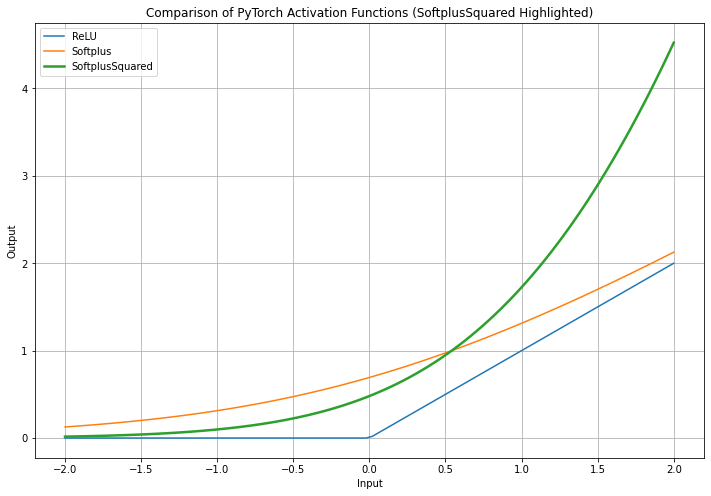

In [36]:
# Define the SoftplusSquared activation function
class SoftplusSquared(nn.Module):
    def forward(self, x):
        return torch.log(1 + torch.exp(x)) ** 2

activations = {
    "ReLU": nn.ReLU(),
    # "LeakyReLU": nn.LeakyReLU(),
    # "ELU": nn.ELU(),
    # "SELU": nn.SELU(),
    "Softplus": nn.Softplus(),
    # "Sigmoid": nn.Sigmoid(),
    # "Tanh": nn.Tanh(),
    "SoftplusSquared": SoftplusSquared()}

x_values = torch.linspace(-2, 2, 100)
plt.figure(figsize=(12, 8))
for name, activation in activations.items():
    y_values = activation(x_values).detach().numpy()
    if name == "SoftplusSquared":
        plt.plot(x_values.numpy(), y_values, label=name, linewidth=2.5)
    else:
        plt.plot(x_values.numpy(), y_values, label=name)
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("Comparison of PyTorch Activation Functions (SoftplusSquared Highlighted)")
plt.legend()
plt.grid(True)
plt.show()


In [37]:
# Define a Linear layer with non-negative weights for ICNN
class NonNegativeLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NonNegativeLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        # Apply ReLU to the weights to ensure non-negativity
        self.linear.weight.data = torch.abs(self.linear.weight.data)
        self.linear.bias.data = torch.abs(self.linear.bias.data)

    def forward(self, x):
        # ReLU on weights to maintain non-negativity
        return torch.nn.functional.linear(x, torch.relu(self.linear.weight), self.linear.bias)
    


In [38]:

# Define the FICNN model for W_{(\theta)} with 1D strain
class PotentialW_FICNN(nn.Module):
    def __init__(self):
        super(PotentialW_FICNN, self).__init__()
        self.fc = nn.Sequential(
            NonNegativeLinear(1, 64),  # Input layer with non-negative weights
            SoftplusSquared(),
            NonNegativeLinear(64, 64), # Hidden layer 1 with non-negative weights
            SoftplusSquared(),
            NonNegativeLinear(64, 64), # Hidden layer 2 with non-negative weights
            SoftplusSquared(),
            NonNegativeLinear(64, 1)   # Output layer with non-negative weights
        )
# passthrough ****
    def forward(self, strain):
        # Compute N_theta(strain) using the FICNN
        # strain=strain_mean- SDv
        n_theta = self.fc(strain)
        # n_theta= n_theta* SDV_thets
    
        # Compute the gradient term d(N_theta)/d(strain) at strain = 0
        strain_zero = torch.tensor([0.0], requires_grad=True)
        n_theta_zero = self.fc(strain_zero)
        gradient = torch.autograd.grad(n_theta_zero, strain_zero, create_graph=True)[0]

        # Compute W(theta) as N_theta - gradient * strain
        W_theta = n_theta - gradient * strain
        return W_theta

In [39]:
# Define the FICNN for V_{(\Phi)} with learned parameters C1 and C2
class PotentialV_FICNN(nn.Module):
    def __init__(self):
        super(PotentialV_FICNN, self).__init__()
        # Define the neural network for M_{Phi} with 4 hidden layers
        self.fc = nn.Sequential(
            NonNegativeLinear(1, 64),  # Input layer with non-negative weights
            SoftplusSquared(),
            NonNegativeLinear(64, 64), # Hidden layer 1 with non-negative weights
            SoftplusSquared(),
            NonNegativeLinear(64, 64), # Hidden layer 2 with non-negative weights
            SoftplusSquared(),
            NonNegativeLinear(64, 1)   # Output layer with non-negative weights
        )
        # Define learnable parameters C1 and C2
        self.C1 = nn.Parameter(torch.tensor([1.0]), requires_grad=True)
        self.C2 = nn.Parameter(torch.tensor([1.0]), requires_grad=True)

    def forward(self, strain, alpha):
        # Calculate the input to the network: delta = C1 * strain + C2 * alpha
        delta = self.C1 * strain + self.C2 * alpha

        # Compute M_phi(delta) using the FICNN
        m_phi = self.fc(delta)

        # Compute the gradient term d(M_phi)/d(delta) at delta = 0
        delta_zero = torch.tensor([0.0], requires_grad=True)
        m_phi_zero = self.fc(delta_zero)
        gradient = torch.autograd.grad(m_phi_zero, delta_zero, create_graph=True)[0]

        # Compute V_phi as M_phi - gradient * delta
        V_phi = m_phi - gradient * delta
        return V_phi


In [40]:
# Define the FICNN for G_{(\Gamma)} with full input convexity over beta and E
class PotentialG_FICNN(nn.Module):
    def __init__(self):
        super(PotentialG_FICNN, self).__init__()
        
        # Define the fully convex network with respect to both beta and E
        self.fc = nn.Sequential(
            NonNegativeLinear(2, 64),  # Convex layer with respect to beta and E
            SoftplusSquared(),
            NonNegativeLinear(64, 64), # Convex hidden layer 1
            SoftplusSquared(),
            NonNegativeLinear(64, 64), # Convex hidden layer 2
            SoftplusSquared(),
            NonNegativeLinear(64, 1)   # Output layer, convex with respect to beta and E
        )

    def forward(self, beta, strain):
        # Concatenate beta and strain as the input
        input_data = torch.cat([beta, strain], dim=-1)  # Shape: (batch_size, 2)

        # Compute D_gamma(beta, epsilon) using the FICNN
        d_gamma = self.fc(input_data)

        # Compute the gradient term d(D_gamma)/d(beta) at beta = 0 for linear correction
        beta_zero = torch.tensor([0.0], requires_grad=True).view(1, 1)
        strain_fixed = strain.view(1, 1)
        input_zero = torch.cat([beta_zero, strain_fixed], dim=-1)
        d_gamma_zero = self.fc(input_zero)

        # Calculate the gradient with respect to beta at beta = 0
        gradient = torch.autograd.grad(d_gamma_zero, beta_zero, create_graph=True)[0]

        # Compute G_gamma as D_gamma - gradient * beta
        G_gamma = d_gamma - gradient * beta
        return G_gamma


In [41]:

# Define the PICNN for G_{(\Gamma)} with convexity in beta and not in E
class PotentialG_PICNN(nn.Module):
    def __init__(self):
        super(PotentialG_PICNN, self).__init__()
        
        # Define beta-path (convex with respect to beta)
        self.beta_path = nn.Sequential(
            NonNegativeLinear(1, 64),  # Convex layer with respect to beta
            SoftplusSquared(),
            NonNegativeLinear(64, 64), # Convex hidden layer
            SoftplusSquared()
        )

        # Define E-path (non-convex with respect to E)
        self.epsilon_path = nn.Sequential(
            nn.Linear(1, 64),          # Standard linear layer, no non-negativity constraint
            SoftplusSquared(),
            nn.Linear(64, 64),  # Another non-convex hidden layer
            SoftplusSquared()
        )

        # Final layer combining both paths, convex with respect to beta
        self.output_layer = NonNegativeLinear(64, 1)  # Ensure convexity with respect to beta     # recheck

    def forward(self, beta, strain):
        # Compute the output of the beta path (convex path)
        beta_out = self.beta_path(beta)

        # Compute the output of the epsilon path (non-convex path)
        epsilon_out = self.epsilon_path(strain)

        # Combine the outputs of both paths
        combined = beta_out * epsilon_out  # Hadamard product allows interaction between beta and epsilon paths

        # Final output layer that ensures convexity with respect to beta
        d_gamma = self.output_layer(combined)

        # Compute the gradient term d(D_gamma)/d(beta) at beta = 0 for linear correction
        beta_zero = torch.tensor([0.0], requires_grad=True).view(1, -1)
        beta_out_zero = self.beta_path(beta_zero)
        epsilon_out_fixed = self.epsilon_path(strain)  # epsilon path evaluated at given strain
        combined_zero = beta_out_zero * epsilon_out_fixed
        d_gamma_zero = self.output_layer(combined_zero)

        # Calculate the gradient with respect to beta at beta = 0
        gradient = torch.autograd.grad(d_gamma_zero, beta_zero, create_graph=True)[0]

        # Compute G_gamma as D_gamma - gradient * beta
        G_gamma = d_gamma - gradient * beta
        return G_gamma


In [42]:
class AlphaSurrogate(nn.Module):
    def __init__(self):
        super(AlphaSurrogate, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 64),           # Input layer
            SoftplusSquared(),
            nn.Linear(64, 64),          # Hidden layer 1
            SoftplusSquared(),
            nn.Linear(64, 64),          # Hidden layer 2
            SoftplusSquared(),
            nn.Linear(64, 64),          # Hidden layer 3
            SoftplusSquared(),
            nn.Linear(64, 1)            # Output layer
        )

    def forward(self, t):
        return self.fc(t)

In [43]:
# Define the complete viscoelastic model with alpha surrogate
class ViscoelasticModelWithAlpha(nn.Module):
    def __init__(self, W_model, V_model, G_model, alpha_surrogate):
        super(ViscoelasticModelWithAlpha, self).__init__()
        self.W_model = W_model
        self.V_model = V_model
        self.G_model = G_model
        self.alpha_surrogate = alpha_surrogate

    def forward(self, strain, alpha, t):
        # Step 1: Compute internal stress beta using V_model
        V = self.V_model(strain, alpha)
        V_sum = V.sum()
        beta = -grad(V_sum, alpha, create_graph=True)[0]

        # Step 2: Evolve alpha using G_model and surrogate
        alpha_evolution = self.G_model(strain, beta)
        alpha_surrogate = self.alpha_surrogate(t)

        # Step 3: Compute total stress using W_model and V_model
        W = self.W_model(strain)
        dW_dE = grad(W.sum(), strain, create_graph=True)[0]
        dV_dE = grad(V_sum, strain, create_graph=True)[0]
        total_stress = dW_dE + dV_dE

        return total_stress, alpha_evolution, alpha_surrogate


In [44]:
# Define the augmented loss function with penalty
def augmented_loss(predicted_stress, true_stress, alpha_surrogate, alpha_evolution, lambda_penalty=0.1):
    mse_loss = nn.MSELoss()(predicted_stress, true_stress)
    penalty_loss = lambda_penalty * torch.mean((alpha_surrogate - alpha_evolution) ** 2)
    total_loss = mse_loss + penalty_loss
    return total_loss

# Instantiate the models
W_model = PotentialW_FICNN()
V_model = PotentialV_FICNN()
G_model = PotentialG_PICNN()
alpha_surrogate = AlphaSurrogate()

# Instantiate the viscoelastic model with the alpha surrogate
viscoelastic_model = ViscoelasticModelWithAlpha(W_model, V_model, G_model, alpha_surrogate)

# Define the optimizer
optimizer = optim.Adam(viscoelastic_model.parameters(), lr=0.001)


# from Faisal:
# params = list(model_M.parameters()) + list(model_N.parameters()) + list(model_D.parameters()) + list(model_alpha.parameters())
#

# Training loop
epochs = 5000
for epoch in range(epochs):
    # Loop through the data loader batches
    for batch_idx, (strain_batch, true_stress_batch) in enumerate(data_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Ensure strain_batch requires grad for computing potentials W, V, and G
        strain_batch.requires_grad_(True)

        # Initialize alpha with requires_grad=True so we can compute gradients for alpha evolution
        alpha = torch.zeros_like(strain_batch, requires_grad=True)

        # Forward pass: compute predicted stress, alpha evolution, and surrogate alpha
        predicted_stress, alpha_evolution, alpha_surrogate_output = viscoelastic_model(strain_batch, alpha, t)

        # Compute the augmented loss (MSE + penalty for alpha evolution)
        loss = augmented_loss(predicted_stress, true_stress_batch, alpha_surrogate_output, alpha_evolution)

        # Backward pass: compute gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

    # Print loss for monitoring every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')



ValueError: too many values to unpack (expected 2)

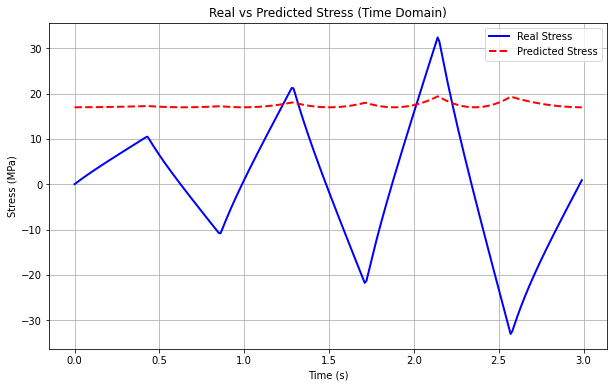

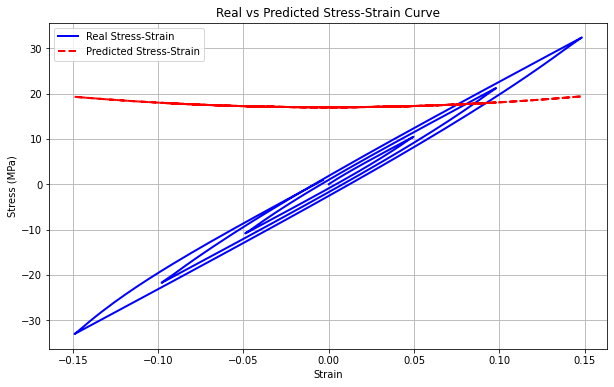

: 

In [6]:
# Evaluate the model and compare with real stress
viscoelastic_model.eval()

# Forward pass to get predictions on the full dataset
with torch.no_grad():
    # Initialize alpha for inference without requires_grad=True
    alpha = torch.zeros_like(strain_tensor)

    # Forward pass through the model to get predictions without computing gradients
    predicted_stress_list = []

      
    # Iterate over each strain value in the dataset
    for i in range(len(strain_tensor)):
        strain = strain_tensor[i].unsqueeze(0)  # Shape (1, 1)
        alpha_i = alpha[i].unsqueeze(0)  # Shape (1, 1)

        # Use the model to compute stress using the learned potentials without needing gradients
        W_output = W_model(strain)
        V_output = V_model(strain, alpha_i)

        # Here we directly use the outputs from W_model and V_model as stress approximation
        total_stress = W_output + V_output

        # Collect the predicted stress
        predicted_stress_list.append(total_stress.item())

    # Convert the list of predicted stresses to a numpy array for plotting
    predicted_stress = np.array(predicted_stress_list)

# Convert strain and stress to numpy arrays for easier plotting
strain_np = strain_tensor.squeeze().numpy()  # Shape (N,)
stress_np = stress_tensor.squeeze().numpy()  # Shape (N,)

# Plot the real vs predicted stress vs time
plt.figure(figsize=(10, 6))
plt.plot(time, stress_np, label="Real Stress", color='b', linewidth=2)
plt.plot(time, predicted_stress, label="Predicted Stress", color='r', linestyle='--', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Stress (MPa)")
plt.title("Real vs Predicted Stress (Time Domain)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the real vs predicted stress-strain curve
plt.figure(figsize=(10, 6))
plt.plot(strain_np, stress_np, label="Real Stress-Strain", color='b', linewidth=2)
plt.plot(strain_np, predicted_stress, label="Predicted Stress-Strain", color='r', linestyle='--', linewidth=2)
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Real vs Predicted Stress-Strain Curve")
plt.legend()
plt.grid(True)
plt.show()
